In [30]:
import sys
sys.path.insert(0, "../")
import os
import logging
import time
import warnings
import json
import numpy
import torch
import matplotlib
import torchaudio
import torchvision.transforms as transforms
import torchaudio
import nevergrad
import cma
import dave_models
from matplotlib import pyplot
from pytorch_lightning.utilities.seed import seed_everything
from tqdm.notebook import tqdm
from dataloaders.image_caption_dataset import ImageCaptionDataset
from speech2image.model import Speech2Image
from IPython.display import Audio

%matplotlib inline

## Load data and models

In [53]:
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

In [77]:
model_path = "../checkpoints_speech2image/stylegan2-051221_2133/speech2image_epoch=0227.ckpt"
assert os.path.isfile(model_path), sorted(os.listdir(os.path.dirname(model_path)))[-1]

In [78]:
model = Speech2Image().cuda()
model.load_state_dict(torch.load(model_path, map_location=model.device)["state_dict"], strict=False)

INFO:root:Vocabulary size: 5000


_IncompatibleKeys(missing_keys=['aug.ada_aug_buf'], unexpected_keys=[])

In [79]:
dataset = "../data/hotel_room_classroom_living_room_kitchen_office_test.json"
model_dir = "./trained_models"
davenet_path = os.path.join(model_dir, "davenet_vgg16_MISA_1024_pretrained/")
audio_model, image_model = dave_models.DAVEnet_model_loader(os.path.join(davenet_path, "audio_model.pth"), os.path.join(davenet_path, "image_model.pth"))

In [80]:
audio_conf = {"audio_type": "both", "use_raw_length": True}
vdataset = ImageCaptionDataset(dataset, audio_conf=audio_conf, image_conf={"center_crop": True}, normalize=False)
vdataset.audio_base_path = os.path.join("../", vdataset.audio_base_path)
vdataset.image_base_path = os.path.join("../", vdataset.image_base_path)
data_key = {x["wav"]:x for x in vdataset.data}
loader = torch.utils.data.DataLoader(vdataset, shuffle=True, num_workers=8, batch_size=1)

In [81]:
_ = model.eval()

## Select example

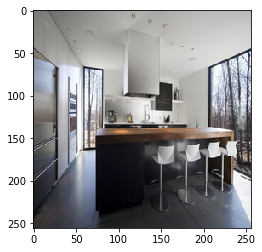

In [145]:
warnings.filterwarnings("ignore")

seed_everything(time.time())
n = numpy.random.randint(100)
for i, (image, (audio, spec), _, apath) in enumerate(loader):
    if i == n:
        break
pyplot.imshow(image[0].permute(1, 2, 0).cpu().numpy())
Audio(apath[0])

In [54]:
mel = torchaudio.transforms.MelSpectrogram(n_mels=40).cuda() # May not need this

In [83]:
audio_model = audio_model.cuda()
image_model = image_model.cuda()

## Optimization Setup

In [103]:
def get_imagefeatures(img):
    image_feature_map = image_model(img.unsqueeze(0)).squeeze(0)
    emb_dim = image_feature_map.size(0)
    output_H = image_feature_map.size(1)
    output_W = image_feature_map.size(2)
    return image_feature_map.view(emb_dim, output_H * output_W), (emb_dim, output_H, output_W)

def get_audiofeatures(melspec):
    audio_output = audio_model(melspec.unsqueeze(0).unsqueeze(0)).squeeze(0)
    return audio_output

def score(melspec, img):
    image_output, image_dim = get_imagefeatures(img)
    audio_output = get_audiofeatures(melspec)
    _, img_outputH, img_outputW = image_dim
    heatmap = torch.mm(audio_output.t(), image_output).squeeze()
    heatmap = heatmap.view(audio_output.size(1), img_outputH, img_outputW)
    N_t = audio_output.size(1)
    N_r = img_outputH
    N_c = img_outputW
    sisa = torch.sum(heatmap) / (N_t * N_r * N_c)
    misa = torch.sum(torch.amax(heatmap.view(N_t, N_r * N_c), dim=1))/(N_t)
    sima = torch.sum(torch.amax(heatmap, dim=1)) / (N_r * N_c)
    return misa

In [154]:
print(score(spec[0].cuda(), image[0].cuda()))

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same

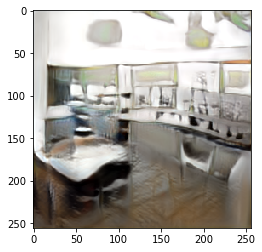

In [152]:
seed_everything(time.time())
z = torch.nn.Parameter(torch.zeros(1, 1, 512, device="cuda"))
opt = torch.optim.Adam([z])

seed_everything(0)
x = model.enc(audio).mean(dim=1).view(1, 1, 512).cuda()
audio = audio.cuda()
n = torch.cat([x, z], dim=0).unbind(0)
fake_img, _ = model.G_EMA(n, randomize_noise=False)
pyplot.imshow(fake_img[0].permute(1, 2, 0).detach().cpu().numpy())

In [153]:
print(score(spec[0].cuda(), fake_img[0]))

tensor(-2.3978, device='cuda:0', grad_fn=<DivBackward0>)


## Optimization w/ Adam (gradient-based)

In [106]:
# n_steps = 100
# l = tqdm(range(n_steps))
# for i in l:
#     opt.zero_grad()
#     seed_everything(0)
#     n = torch.cat([x, z], dim=0).unbind(0)
#     fake_img, _ = model.G_EMA(n)
#     s = -score(mel(audio)[0], fake_img[0])
#     s.backward(retain_graph=i != (n_steps - 1))
#     l.set_postfix(l=s.item())
#     opt.step()
#     if i % (n_steps//10) == 0:
#         fimg = fake_img[0].permute(1, 2, 0).detach().cpu().numpy()
#         pyplot.imshow((fimg - fimg.min())/(fimg.max() - fimg.min()))
#         pyplot.savefig("test%d.png" % i)

## Optimization with CMA-ES (non-gradient-based)

In [148]:
x0 = z.squeeze().detach().cpu().numpy()

# create the CMA-ES optimizer
es = cma.CMAEvolutionStrategy(
    x0=x0,
    sigma0=1000,
    inopts={"popsize": 50},
)


def f(xs):
    seed_everything()
    xs = torch.tensor(xs, device=z.device, dtype=z.dtype).view(x.shape)
    return -score(spec.cuda()[0], model.G_EMA(torch.cat([x, xs]), randomize_noise=False)[0][0]).item()

with torch.no_grad():
    r = es.optimize(f, iterations=100)

(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 512 (seed=374789, Mon May 17 20:35:21 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     50 1.657279491424561e+00 1.0e+00 9.78e+02  1e+03  1e+03 0:01.5
    2    100 1.854952692985535e+00 1.0e+00 9.60e+02  1e+03  1e+03 0:03.0
    3    150 1.384917855262756e+00 1.0e+00 9.44e+02  9e+02  9e+02 0:04.6
    5    250 1.202399015426636e+00 1.0e+00 9.21e+02  9e+02  9e+02 0:07.9
    8    400 9.362198710441589e-01 1.0e+00 8.99e+02  9e+02  9e+02 0:12.5
   12    600 5.754614472389221e-01 1.0e+00 8.83e+02  9e+02  9e+02 0:18.6
   16    800 1.523248404264450e-01 1.0e+00 8.82e+02  9e+02  9e+02 0:24.9
   21   1050 -1.504182517528534e-01 1.0e+00 8.93e+02  9e+02  9e+02 0:32.5
   27   1350 -1.453203111886978e-01 1.0e+00 9.18e+02  9e+02  9e+02 0:41.8
   33   1650 -1.652417480945587e-01 1.0e+00 9.52e+02  1e+03  1e+03 0:50.8
   40   2000 -1.433759629726410e-01 1.0e+00 1.01e+03  1e+03  1e+03 1:01.7
   48   2400 -2.8193092346

In [149]:
best_x = torch.from_numpy(r.result.xbest).float().cuda()
z = best_x

## Resulting Image

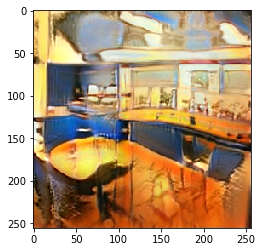

In [150]:
seed_everything(0)
n = torch.cat([x, z.view(1, 1, 512)], dim=0).unbind(0)
f_img, _ = model.G_EMA(n, randomize_noise=False)
pyplot.imshow(f_img[0].permute(1, 2, 0).detach().cpu().numpy())

In [151]:
print(score(spec[0].cuda(), f_img[0]))

tensor(1.2305, device='cuda:0', grad_fn=<DivBackward0>)
